# HW4: Neural Network

(Cập nhật lần cuối: 06/05/2024)

Họ tên: Lê Thanh Thái Quảng

MSSV: 21120123

---

## Kiểm tra môi trường code

In [1]:
import sys
sys.executable

'/home/thaiquang03/miniconda3/envs/anaconda/bin/python'

Bạn nên thấy kết quả in ra là đường dẫn đến file chạy python của môi trường "ml-env" mà mình đã hướng dẫn bạn cài đặt ở HW0.

## Nắm bài toán cần giải quyết của bài tập này

Cho dữ liệu quan sát được (đây là dữ liệu huấn luyện gốc, dữ liệu này thường sẽ được tách ra một phần làm dữ liệu validation): 
$$\{(\textbf{x}^{(1)}, y^{(1)}), ..., (\textbf{x}^{(N_{train})}, y^{(N_{train})})\}$$

Trong đó:

- $\textbf{x}^{(n)} \in \mathbb{R}^{784}$ là véc-tơ đầu vào chứa các giá trị pixel của một ảnh xám $28\times28$, ảnh này là ảnh một chữ số viết tay nào đó (véc-tơ $784$ chiều được tạo từ ảnh xám $28\times28$ bằng cách nối các dòng của ảnh xám lại với nhau)
- $y^{(n)} \in \{0, 1, ..., 9\}$ là đầu ra tương ứng, cho biết đây là chữ số nào

Nhiệm vụ ở đây là tìm ra một (cách tiền xử lý +) mô hình Neural Network từ dữ liệu này sao cho (cách tiền xử lý +) mô hình Neural Network này có thể nhận đầu vào là một ảnh-chữ-số-viết-tay *mới* (là một véc-tơ $\in \mathbb{R}^{784}$) và dự đoán đầu ra tương ứng (chữ số nào trong $\{0, 1, 2, ..., 9\}$) một cách *chính xác*.

## Import các thư viện cần thiết

In [2]:
import numpy as np
import os
import pickle
import gzip
import matplotlib.pyplot as plt
plt.style.use('ggplot') # Để hình vẽ đẹp hơn một xíu ...

Lưu ý: khi tính toán với mảng Numpy, bạn nên dùng các toán-tử/hàm/phương-thức mà Numpy đã cung cấp sẵn. Các toán-tử/hàm/phương-thức này làm trên nguyên mảng và ở bên dưới đã được tối ưu hóa; do đó, code sẽ ngắn gọn và chạy nhanh. Nếu bạn dùng vòng lặp for và làm với từng phần tử của mảng Numpy thì code sẽ dài và chạy chậm $\to$ bạn sẽ bị trừ điểm.

## Đọc dữ liệu (giống HW2 & HW3)

Bộ dữ liệu mà ta sẽ dùng trong bài này là MNIST - bộ dữ liệu chữ số viết tay "nổi tiếng" trong cộng đồng làm Machine Learning. [Bộ MNIST gốc](http://yann.lecun.com/exdb/mnist/) gồm có: dữ liệu huấn luyện (60000 ảnh) và dữ liệu kiểm tra (10000 ảnh). Bộ MNIST mà ta sẽ dùng trong bài này (file "mnist.pkl.gz") gồm có: dữ liệu huấn luyện (50000 ảnh), dữ liệu validation (10000 ảnh), và dữ liệu kiểm tra (10000 ảnh); dữ liệu huấn luyện và validation ở đây được tạo ra bằng cách tách ngẫu nhiên dữ luyện huấn luyện gốc ra thành 2 phần theo tỉ lệ 5:1. 

Về mặt ý nghĩa thì dữ liệu validation và dữ liệu kiểm tra đều là dữ liệu mới ngoài dữ liệu huấn luyện. Dữ liệu validation giống như đề thi thử, có thể được thi một vài lần; còn dữ liệu kiểm tra giống như đề thi thật, để đảm bảo kết quả được khách quan thì chỉ được thi một lần duy nhất! Khi làm Machine Learning, ta thường muốn thử một số cách tiền xử lý + mô hình để chọn ra cách tiền xử lý + mô hình tốt nhất. Với mỗi cách tiền xử lý + mô hình, ta sẽ huấn luyện trên dữ liệu huấn luyện và đo độ lỗi dự đoán trên dữ liệu validation; cuối cùng ta sẽ chọn cách tiền xử lý + mô hình mà có độ lỗi dự đoán thấp nhất trên dữ liệu validation (ta không chọn dựa vào độ lỗi dự đoán trên dữ liệu huấn luyện vì có thể xảy ra trường hợp "học vẹt": cách tiền xử lý + mô hình có độ lỗi rất thấp trên dữ liệu huấn luyện nhưng lại có độ lỗi cao với dữ liệu mới ngoài dữ liệu huấn luyện). Khi đã chọn xong cách tiền xử lý + mô hình rồi thì ta sẽ đo một lần duy nhất độ lỗi dự đoán trên dữ liệu kiểm tra để có một ước lượng khách quan về độ lỗi thật sự! Nếu bạn nhìn vào độ lỗi dự đoán trên dữ liệu kiểm tra và quay lại điều chỉnh cách tiền xử lý + mô hình thì kết quả trên dữ liệu kiểm tra sẽ không còn sự khách quan nữa!

Đoạn code dưới đây sẽ đọc dữ liệu từ file "mnist.pkl.gz" và lưu kết quả vào 6 mảng:

- `train_X`, `train_y`
- `val_X`, `val_y`
- `test_X`, `test_y`

In [3]:
def read_mnist(mnist_file):
    if os.path.isfile(mnist_file) == False:
        mnist_file = os.path.join(os.path.expanduser('~'), 'data', 'mnist.pkl.gz')
    
    f = gzip.open(mnist_file, 'rb')
    train_data, val_data, test_data = pickle.load(f, encoding='latin1')
    f.close()
    
    train_X, train_Y = train_data
    val_X, val_Y = val_data
    test_X, test_Y = test_data    
    
    return train_X, train_Y, val_X, val_Y, test_X, test_Y

# Bạn cần đặt file "mnist.pkl.gz" vào cùng thư mục với file notebook này,
# hoặc bạn cũng có thể đặt ở thư mục tương ứng với câu lệnh này:
# os.path.join(os.path.expanduser('~'), 'data')
train_X, train_y, val_X, val_y, test_X, test_y = read_mnist('Data/mnist.pkl.gz')
print(f'Shape of train_X: {train_X.shape}, shape of train_y: {train_y.shape}')
print(f'Shape of val_X:   {val_X.shape}, shape of val_y:   {val_y.shape}')
print(f'Shape of test_X:  {test_X.shape}, shape of test_y:  {test_y.shape}')

Shape of train_X: (50000, 784), shape of train_y: (50000,)
Shape of val_X:   (10000, 784), shape of val_y:   (10000,)
Shape of test_X:  (10000, 784), shape of test_y:  (10000,)


## Khám phá dữ liệu huấn luyện (giống HW2 & HW3)

Đầu tiên, ta hãy xem thử min và max của `train_X`.

In [4]:
print(f'Min of train_X: {train_X.min()}, max of train_X: {train_X.max()}')

Min of train_X: 0.0, max of train_X: 0.99609375


Với ảnh xám thì giá trị của mỗi pixel thường sẽ nằm trong đoạn [0, 255] (với 0 là màu đen và 255 là màu trắng), hoặc đôi khi được chuẩn hóa về đoạn [0, 1] (với 0 là màu đen và 1 là màu trắng). Ở đây có vẻ giá trị pixel của ảnh xám của ta nằm trong đoạn [0, 1].

Tiếp theo, ta hãy thử xem mặt mũi của vài ảnh trong `train_X`.

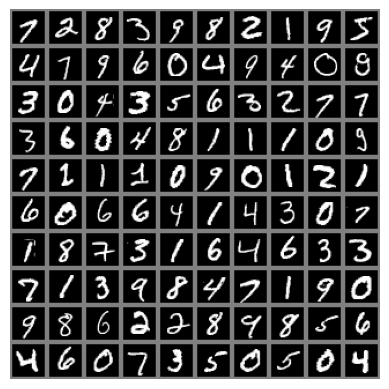

In [5]:
# Bạn có thể chạy cell này nhiều lần để xem các ảnh ngẫu nhiên khác nhau
n_rimages = 10; n_cimages = 10 
padding = 2 
canvas = 0.5 * np.ones((n_rimages * (28 + 2 * padding), n_cimages * (28 + 2 * padding)))
rand_idxs = np.random.permutation(np.arange(len(train_X))[:n_rimages * n_cimages])
for r in range(n_rimages):
    for c in range(n_cimages):
        i = r * n_cimages + c
        image = train_X[rand_idxs[i]].reshape(28, 28)
        temp1 = r * (28 + 2 * padding) + padding 
        temp2 = c * (28 + 2 * padding) + padding 
        canvas[temp1:temp1 + 28, temp2:temp2 + 28] = image
plt.imshow(canvas, cmap='gray', vmin=0, vmax=1)
plt.axis('off');

Tiếp theo, ta hãy xem các giá trị có thể có của `train_y` và số lượng của mỗi giá trị này.

In [6]:
values, counts = np.unique(train_y, return_counts=True)
for value, count in zip(values, counts):
    print(f'Value: {value}, count: {count}')

Value: 0, count: 4932
Value: 1, count: 5678
Value: 2, count: 4968
Value: 3, count: 5101
Value: 4, count: 4859
Value: 5, count: 4506
Value: 6, count: 4951
Value: 7, count: 5175
Value: 8, count: 4842
Value: 9, count: 4988


Như vậy là `train_y` có 10 giá trị có thể có ứng với 10 chữ số từ 0 đến 9. Và số lượng ảnh của mỗi chữ số cũng khá tương đương nhau. Tốt ...

## Tiền xử lý dữ liệu huấn luyện

In [7]:
def add_ones(X):
    return np.hstack((np.ones((len(X), 1)), X))

# Gọi hàm add_ones để tiền xử lý train_X
train_Z = add_ones(train_X)
train_Z.shape

(50000, 785)

## Tìm mô hình Neural Network từ dữ liệu huấn luyện

Trong bài này, ta sẽ làm với một kiến trúc đơn giản của mô hình Neural Network: Fully-Connected Feed-Forward Neural Network. Ta sẽ dùng hàm kích hoạt sigmoid ở tầng ẩn và hàm softmax ở tầng đầu ra. Như vậy, có thể xem mô hình Neural Network của ta là mô hình Softmax Regression mà có véc-tơ đầu vào là $\textbf{z}$ với $\textbf{z}$ được tính từ véc-tơ đầu vào ban đầu $\textbf{x}$ thông qua các tầng ẩn. Ý tưởng lớn của mô hình Neural Network là mô hình sẽ tự động học luôn cách xác định véc-tơ đầu vào $\textbf{z}$ từ dữ liệu, thay vì con người phải ngồi suy nghĩ cách thiết kế $\textbf{z}$. Ưu điểm của cách làm này của mô hình Neural Network là con người có thể để cho máy tính chạy và đi uống coffee :-). Nhưng nhược điểm là mô hình sẽ có nhiều tham số (trọng số) cần phải học hơn, và do đó sẽ cần nhiều dữ liệu hơn để có thể học tốt; điều này cũng có nghĩa là sẽ cần máy tính mạnh hơn, huấn luyện lâu hơn, tốn tiền điện nhiều hơn, thải CO2 ra môi trường nhiều hơn :-(. Một nhược điểm nữa là con người có thể không hiểu được véc-tơ đầu vào $\textbf{z}$ mà mô hình đưa ra. Về độ chính xác dự đoán, cho đến thời điểm hiện tại mô hình Neural Network là mô hình đạt được độ chính xác dự đoán rất tốt với dữ liệu hình ảnh, âm thanh, văn bản.

Quay trở lại việc cài đặt mô hình Neural Network trong bài này, nhiệm vụ 1 của bạn (2đ): viết hàm `compute_nnet_output`. Hàm này sẽ được dùng trong hàm `train_nnet` ở bên dưới; ngoài ra, sau khi huấn luyện xong thì hàm này sẽ được dùng để dự đoán các đầu ra của các véc-tơ đầu vào mới.

Hàm `compute_nnet_output` có các tham số đầu vào:
- `Ws`: list chứa các mảng trọng số của mô hình Neural Network. `Ws[l-1]` là mảng trọng số của tầng `l` với `l` >= 1 (tầng 0 là tầng đầu vào, không có mảng trọng số); mảng trọng số của tầng `l` có shape là <font color=blue>(</font>1 + số lượng nơ-ron của tầng `l-1`<font color=blue>,</font> số lượng nơ-ron của tầng `l`<font color=blue>)</font> với "số lượng nơ-ron của tầng" là không tính nơ-ron mà luôn có giá trị đầu ra là 1
- `X`: mảng chứa các véc-tơ đầu vào cần dự đoán (đã được thêm 1 ở đầu), mảng này có shape là (`N`, `d+1`) với `N` là số lượng các véc-tơ đầu vào và `d` là số lượng phần tử của mỗi véc-tơ đầu vào (khi chưa thêm 1 ở đầu)
- `return_what`: nếu tham số này bằng `all` thì sẽ trả về list chứa các mảng-chứa-các-véc-tơ-đầu-ra ở tất cả các tầng (ta sẽ cần dùng list này trong quá trình huấn luyện); nếu tham số này bằng `prob` thì sẽ trả về mảng chứa các véc-tơ đầu ra ở tầng đầu ra, mỗi véc-tơ đầu ra cho biết xác suất các lớp của véc-tơ đầu vào tương ứng; nếu tham số này bằng `class` hoặc các giá trị khác thì sẽ trả về mảng chứa các lớp đầu ra dự đoán, lớp đầu ra dự đoán của một véc-tơ đầu vào là lớp mà có xác suất lớn nhất trong véc-tơ đầu ra chứa xác suất các lớp

Hàm `compute_nnet_output` sẽ trả về:

- Nếu `return_what` bằng `all` thì sẽ trả về list chứa các mảng-chứa-các-véc-tơ-đầu-ra ở tất cả các tầng, bao gồm cả tầng 0 (tầng đầu vào). Phần tử chỉ số `i` của list này là mảng chứa các véc-tơ đầu ra của tầng `i` tương ứng với các véc-tơ đầu vào của `X`; mảng này có shape là (`N`, 1 + số lượng nơ-ron của tầng `i`) nếu mảng này không phải là phần tử cuối của list ("1 + ..." là ứng với giá trị 1 của nơ-ron mà luôn có giá trị đầu ra là 1), còn nếu mảng này là phần tử cuối của list (tầng đầu ra) thì sẽ có shape là (`N`, số lượng nơ-ron của tầng `i`). Nhắc lại: "số lượng nơ-ron của tầng" là không tính nơ-ron mà luôn có giá trị đầu ra là 1, `N` là số lượng véc-tơ đầu vào của `X`
- Nếu `return_what` bằng `prob` thì sẽ trả về mảng chứa các véc-tơ đầu ra ở tầng đầu ra mà tương ứng với các véc-tơ đầu vào của `X`, mỗi véc-tơ đầu ra chứa xác suất các lớp của véc-tơ đầu vào tương ứng; mảng này có shape là (`N`, số lượng lớp)
- Nếu `return_what` bằng `class` hoặc các giá trị khác thì sẽ trả về mảng chứa các lớp đầu ra dự đoán tương ứng với các véc-tơ đầu vào của `X`, lớp đầu ra dự đoán của một véc-tơ đầu vào là lớp mà có xác suất lớn nhất trong véc-tơ đầu ra chứa xác suất các lớp; mảng này có shape là (`N`,)

Trong hàm `compute_nnet_output` thì bạn được phép dùng vòng lặp để duyệt qua các tầng.

In [8]:
def compute_nnet_output(Ws, X, return_what='class'):
    # YOUR CODE HERE
    As = []
    As.append(X)
    for i in range(0, len(Ws)):    
        if i == len(Ws) - 1: # Nếu là tầng cuối cùng thì dùng softmax
            Z = np.matmul(As[-1], Ws[i])
            A = np.exp(Z) / np.exp(Z).sum(axis=1, keepdims=True)
            As.append(A)
        else: # Nếu là tầng ẩn thì dùng sigmoid
            A = 1 / (1 + np.exp(-np.matmul(As[-1], Ws[i])))
            As.append(add_ones(A))
    
    if return_what == "all":
        return As
    elif return_what == "prob":
        return As[-1]
    elif return_what == "class":
        return np.argmax(As[-1], axis=1)

In [9]:
# TEST
# Giả sử ta có mảng X với 4 dòng tương ứng với 4 véc-tơ đầu vào (đã thêm 1 ở đầu)
X = np.array([[1.0, 0.9, 0.9], 
              [1.0, 0.5, 0.4], 
              [1.0, 0.4, 0.5],
              [1.0, 0.1, 0.7]])
# Giả sử Neural Network của ta có:
# 2 nơ-ron đầu vào - 4 nơ-ron ẩn - 3 nơ-ron ẩn - 2 nơ-ron đầu ra
# (không tính nơ-ron mà luôn có giá trị đầu ra là 1)
Ws = [np.array([[-0.3 ,  0.2 ,  0.5 , -0.6],
                [-0.1 , -0.2 , -0.35,  0.1],
                [ 0.45, -0.7 , -0.7 ,  0.9]]),
      np.array([[ 0.3 , -0.05,  0.8],
                [ 0.6 ,  0.3 , -0.5],
                [-0.8 , -0.3 ,  0.5],
                [ 0.4 , -0.45,  0.4],
                [ 0.1 ,  0.2 , -0.3]]),
      np.array([[-0.3 ,  0.6],
                [ 0.5 , -0.7],
                [-0.45,  0.2],
                [ 0.47, -0.2]])]
# Kiểm tra hàm compute_nnet_output của bạn!
As = compute_nnet_output(Ws, X, 'all')
assert len(As) == 4
assert As[0].shape == (4, 3)
assert As[1].shape == (4, 5)
assert As[2].shape == (4, 4)
assert As[3].shape == (4, 2)
assert str(np.round(As[0][0, 1], 4)) == '0.9'
assert str(np.round(As[1][0, 1], 4)) == '0.5037'
assert str(np.round(As[2][0, 1], 4)) == '0.6305'
assert str(np.round(As[3][0, 1], 4)) == '0.5022'
predicted_Y = compute_nnet_output(Ws, X, 'prob')
assert predicted_Y.shape == (4, 2)
assert str(np.round(predicted_Y[0, 1], 4)) == '0.5022'
predicted_y = compute_nnet_output(Ws, X, 'class')
assert predicted_y.shape == (4,)
assert list(predicted_y) == [1, 0, 0, 0]

Sau khi đã xong nhiệm vụ 1 thì bây giờ bạn sẽ sang nhiệm vụ 2 và cũng là nhiệm vụ chính của bạn (4đ): viết hàm `train_nnet` để huấn luyện mô hình Neural Network với độ lỗi cross-entropy và thuật toán cực tiểu hóa SGD (Stochastic Gradient Descent).

Hàm `train_nnet` có các tham số đầu vào:
- `X`, `y`, `initial_Ws`, `mb_size`, `lr`, `max_epoch`: giống như ở HW3, mình sẽ không nhắc lại nữa. Một khác biệt nhỏ so với HW3 là `initial_W` được thay bằng `initial_Ws` (có s), vì bây giờ ta không chỉ có một mảng trọng số mà là một list các mảng trọng số. Ngoài ra, so với HW3 thì ở đây ta chỉ dùng `max_epoch` để ngắt SGD, chứ không có `wanted_mbe` (ở HW3, ta đưa thêm `wanted_mbe` chủ yếu là để so sánh GD và SGD)
- `hid_layer_sizes`: list cho biết số lượng nơ-ron của các tầng ẩn (không tính nơ-ron mà luôn có giá trị đầu ra là 1); ví dụ, list `[20, 10]` nghĩa là Neural Network của ta có 2 tầng ẩn, trong đó tầng ẩn thứ nhất có 20 nơ-ron, tầng ẩn thứ hai có 10 nơ-ron

Hàm `train_nnet` trả về:
- List chứa các mảng trọng số của mô hình Neural Network. Phần tử chỉ số `l-1` của list này là mảng trọng số của tầng `l` với `l` >= 1 (tầng 0 là tầng đầu vào, không có mảng trọng số); mảng trọng số của tầng `l` có shape là <font color=blue>(</font>1 + số lượng nơ-ron của tầng `l-1`<font color=blue>,</font> số lượng nơ-ron của tầng `l`<font color=blue>)</font> với "số lượng nơ-ron của tầng" là không tính nơ-ron mà luôn có giá trị đầu ra là 1
- List chứa độ lỗi cross-entropy trên dữ liệu huấn luyện sau mỗi epoch (giống HW3)

Như đã nói, để tìm các trọng số của mô hình Neural Network thì ta sẽ dùng thuật toán SGD để cực tiểu độ lỗi cross-entropy trên dữ liệu huấn luyện. Như vậy, về cơ bản là hàm `train_nnet` giống như hàm `train_smreg` ở HW3 (ở đây ta cũng thống nhất là sẽ sử dụng cách cài đặt bước "xáo trộn ngẫu nhiên các mẫu dữ liệu huấn luyện" và cách xử lý phần dữ liệu bị lẻ ở cuối giống như ở HW3). Có một điểm khác là ở mỗi mini-batch, ta không chỉ phải cập nhật cho các trọng số của mô hình Softmax Regression ứng với tầng đầu ra, mà còn phải cập nhật cho các trọng số của các tầng ẩn trước đó. 

Như đã biết, trong SGD, để cập nhật cho một trọng số thì ta cần tính trung bình trên mini-batch đạo hàm riêng của độ-lỗi-của-một-mẫu-dữ-liệu-huấn-luyện theo trọng số này. Xét trọng số nối từ nơ-ron i của tầng l-1 tới nơ-ron j của tầng l. Sau khi áp dụng "chain rule" (chi tiết bạn có thể xem ở trang 10-12 của file "HW4-Slide.pdf"), ta có công thức để tính đạo hàm riêng của độ-lỗi-của-một-mẫu-dữ-liệu-huấn-luyện theo trọng số này:

Đạo hàm riêng <font color=blue>=</font> giá trị đầu ra của nơ-ron i ở tầng l-1 <font color=blue>*</font> delta của nơ-ron j ở tầng l

Với delta của một nơ-ron là đạo hàm riêng của độ-lỗi-của-một-mẫu-dữ-liệu-huấn-luyện theo tổng có trọng số (giá trị tính được ngay trước khi áp dụng hàm kích hoạt) của nơ-ron này.

Dưới đây là mã giả của thuật toán SGD để huấn luyện mô hình Neural Network.

===

Khởi tạo các trọng số (lưu ý: với Neural Network, cách khởi tạo trọng số sẽ ảnh hưởng nhiều đến kết quả tìm được bởi SGD)

Với mỗi epoch (một epoch ám chỉ một lần duyệt qua toàn bộ các mẫu dữ liệu huấn luyện):
- Xáo trộn ngẫu nhiên các mẫu dữ liệu huấn luyện
- Chia các mẫu dữ liệu huấn luyện ra thành các mini-batch có kích thước bằng nhau (kích thước này do người dùng chỉ định). Với mỗi mini-batch:
    1. Thực hiện lan truyền tiến các véc-tơ đầu vào qua Neural Network để có được các véc-tơ đầu ra ở tất cả các tầng
    2. Tính các véc-tơ delta của tầng cuối từ các véc-tơ đầu ra của tầng cuối (véc-tơ chứa xác suất các lớp) và các véc-tơ đầu ra đúng của mini-batch (véc-tơ one-hot) 
    3. Tính gradient (các đạo riêng) của tầng cuối từ các véc-tơ đầu ra của tầng kế cuối và các véc-tơ delta của tầng cuối
    4. Cập nhật các trọng số của tầng cuối dựa trên gradient
    5. Duyệt từ tầng kế cuối về đầu. Với tầng i:
        1. Tính các véc-tơ delta của tầng i từ các véc-tơ delta của tầng i+1, các trọng số của tầng i+1, và các véc-tơ đầu ra của tầng i
        2. Tính gradient (các đạo riêng) của tầng i từ các véc-tơ đầu ra của tầng i-1 và các véc-tơ delta của tầng i
        3. Cập nhật các trọng số của tầng i dựa trên gradient

===

Trong mã giả ở trên, bạn đã cài đặt bước 1 ứng với hàm `compute_nnet_output` rồi. Bây giờ mình sẽ đưa ra các ví dụ cụ thể cho các bước 2, 3, 5A, 5B; dựa vào các ví dụ cụ thể này, bạn có thể kiểm tra xem code của bạn cho các bước này đã đúng hay chưa. Nói thêm: thật ra bạn đã làm bước 2 và 3 khi cài đặt mô hình Softmax Regression rồi, nhưng lúc đó bạn không tách ra bước 2.

**Bước 2.** Tính các véc-tơ delta của tầng cuối từ các véc-tơ đầu ra của tầng cuối (véc-tơ chứa xác suất các lớp) và các véc-tơ đầu ra đúng của mini-batch (véc-tơ one-hot)

Giả sử ta có 3 lớp và kích thước của mini-batch là 2. Gọi `A` là mảng 2 chiều chứa các véc-tơ đầu ra của tầng cuối (mỗi véc-tơ là một dòng của mảng) ứng với các véc-tơ đầu vào của mini-batch, và `mb_Y` là mảng 2 chiều chứa các véc-tơ đầu ra đúng của mini-batch (véc-tơ đầu ra đúng là véc-tơ one-hot, mỗi véc-tơ là một dòng của mảng). Nếu:

In [10]:
A = np.array([[0.8, 0.7, 0.6],
              [0.5, 0.6, 0.5]]) 
mb_Y = np.array([[0, 1, 0],
                 [1, 0, 0]])

thì mảng 2 chiều chứa các véc-tơ delta của tầng cuối (mỗi véc-tơ là một dòng của mảng) sẽ bằng:

In [11]:
np.array([[ 0.8, -0.3,  0.6],
          [-0.5,  0.6,  0.5]]);

Bạn có thể xem công thức tính delta của tầng cuối ở trang 14 của file "HW4-Slide.pdf".

**Bước 3.** Tính gradient (các đạo riêng) của tầng cuối từ các véc-tơ đầu ra của tầng kế cuối và các véc-tơ delta của tầng cuối

Giả sử ta có 3 lớp (cũng tức là tầng cuối có 3 nơ-ron), tầng kế cuối có 4 nơ-ron (không tính nơ-ron mà luôn có giá trị đầu ra là 1), và kích thước của mini-batch là 2. Gọi `delta` là mảng 2 chiều chứa các véc-tơ delta của tầng cuối (mỗi véc-tơ là một dòng của mảng) ứng với các mẫu dữ liệu huấn luyện của mini-batch (mẫu dữ liệu huấn luyện gồm véc-tơ đầu vào và đầu ra đúng), và `A` là mảng 2 chiều chứa các véc-tơ đầu ra của tầng kế cuối (mỗi véc-tơ là một dòng của mảng) ứng với các véc-tơ đầu vào của mini-batch. Nếu:

In [12]:
delta = np.array([[ 0.8, -0.3,  0.6],
                  [-0.5,  0.6,  0.5]])
A = np.array([[1.0, 0.5, 0.1, 0.3, 0.2],
              [1.0, 0.9, 0.8, 0.7, 0.1]])

thì gradient của tầng cuối (gradient là mảng có cùng shape với mảng trọng số của tầng cuối) sau khi gọi phương thức `round(4)` (làm tròn 4 chữ số thập phân) sẽ bằng:

In [13]:
np.array([[ 0.15 ,  0.15 ,  0.55 ],
          [-0.025,  0.195,  0.375],
          [-0.16 ,  0.225,  0.23 ],
          [-0.055,  0.165,  0.265],
          [ 0.055,  0.   ,  0.085]]);

Gợi ý: ở trên mình đã có đưa ra công thức để tính đạo hàm riêng của độ-lỗi-của-một-mẫu-dữ-liệu-huấn-luyện theo một trọng số; với một mini-batch thì bạn sẽ dùng công thức này để tính đạo hàm riêng với từng mẫu dữ liệu huấn luyện trong mini-batch, rồi sau cùng là lấy trung bình lại. 

Nếu thấy khó quá thì bạn có thể đoán cách tính gradient từ ví dụ ở trên và hy vọng ... Để củng cố hy vọng, bạn có thể đối chiếu với cách tính gradient của mô hình Softmax Regression mà bạn đã cài đặt ở HW3; như mình đã có nói, thật ra là bạn đã cài đặt bước 2 và 3 ở HW3, nhưng lúc đó là bạn không tách bước 2 ra.

**Bước 5A.** Tính các véc-tơ delta của tầng i từ các véc-tơ delta của tầng i+1, các trọng số của tầng i+1, và các véc-tơ đầu ra của tầng i (lưu ý là ta không tính delta của nơ-ron mà luôn có giá trị đầu ra là 1) 

Giả sử tầng i có 4 nơ-ron, tầng i+1 có 3 nơ-ron (không tính nơ-ron mà luôn có giá trị đầu ra là 1), kích thước của mini-batch là 2. Gọi `delta` là mảng 2 chiều chứa các véc-tơ delta ở tầng i+1 (mỗi véc-tơ là một dòng của mảng) ứng với các mẫu dữ liệu huấn luyện của mini-batch, `W` là mảng 2 chiều chứa các trọng số của tầng i+1, `A` là mảng 2 chiều chứa các véc-tơ đầu ra của tầng i (mỗi véc-tơ là một dòng của mảng) ứng với các véc-tơ đầu vào của mini-batch. Nếu:

In [14]:
delta = np.array([[ 0.8, -0.3,  0.6],
                  [-0.5,  0.6,  0.5]])
W = np.array([[-0.75,  0.95,  0.15],
              [ 0.25,  0.29,  0.97],
              [-0.56,  0.52,  0.73],
              [ 0.05,  0.66,  0.46],
              [-0.05,  0.  , 0.08]])
A = np.array([[1.0, 0.5, 0.1, 0.3, 0.2],
              [1.0, 0.9, 0.8, 0.7, 0.1]])

thì mảng 2 chiều chứa các véc-tơ delta của tầng i (mỗi véc-tơ là một dòng của mảng) sẽ được tính như sau:

In [15]:
delta.dot(W.T[:, 1:]) * A[:, 1:] * (1 - A[:, 1:])

array([[ 0.17375, -0.01494,  0.02478,  0.00128],
       [ 0.04806,  0.15312,  0.12621,  0.00585]])

Do bước này hơi khó nên mình tiết lộ code luôn rồi đó ;-).

**Bước 5B.** Tính gradient (các đạo riêng) của tầng i từ các véc-tơ đầu ra của tầng i-1 và các véc-tơ delta của tầng i

Tương tự như bước 3.

Trước khi bạn viết hàm `train_nnet` thì mình nói thêm ý cuối cùng này nữa. Trong hàm `train_nnet` thì bạn được phép dùng vòng lặp để duyệt qua các epoch, trong mỗi epoch thì bạn được phép dùng vòng lặp để duyệt qua các mini-batch, trong mỗi mini-batch thì bạn được phép dùng vòng lặp để duyệt các tầng của Neural Network. Các bước 2, 3, 4, 5A, 5B, 5C trong mã giả ở trên đều có thể được cài đặt chỉ với một dòng code cho mỗi bước.

In [16]:
def train_nnet(X, y, 
               hid_layer_sizes, 
               initial_Ws, mb_size, lr, max_epoch):
    # Cách để khởi tạo tốt các trọng số khá là "bí hiểm"
    # nên mình sẽ làm cho bạn ;-)
    np.random.seed(0) # Cố định sự ngẫu nhiên để mình và bạn sẽ ra cùng kết quả
    n_classes = len(np.unique(y)) 
    if initial_Ws is None:
        layer_sizes = [X.shape[1] - 1] + hid_layer_sizes + [n_classes]
        Ws = [np.random.randn(layer_sizes[i] + 1, layer_sizes[i + 1]) 
              / np.sqrt(layer_sizes[i] + 1) 
              for i in range(len(layer_sizes) - 1)] 
    else:
        Ws = initial_Ws
    
    # Phần còn lại là của bạn
    # YOUR CODE HERE
    data_indexes = list(range(X.shape[0]))
    n_batch = X.shape[0] // mb_size
    
    cee_set = []
    
    for i in range(0, max_epoch):
        np.random.shuffle(data_indexes)
        for j in range(0, n_batch):
            mini_batch = data_indexes[j * mb_size : j * mb_size + mb_size]
            
            # Tính output của các tầng
            As = compute_nnet_output(Ws, X[mini_batch], return_what="all")
            
            # Tính ma trận Delta của tầng cuối As[-1]
                # Tính onehot của y, nrows là số minibatch
                # Mỗi minibatch ra được y_predict là 1 vector 10 phần tử, mỗi ptu là xác suất của 0 -> 9
            y_one_hot = np.zeros((mb_size, n_classes))
            y_one_hot[np.arange(mb_size), y[mini_batch]] = 1
                # Tính ma trận D
            D = As[-1] - y_one_hot
            
            # Tính gradient của layer cuối
            G = np.dot(As[-2].T, D) / len(As[-2])
            
            # Cập nhật W của layer cuối
            Ws[-1] = Ws[-1] - lr * G
            
            # Ws[len - 1]: tầng cuối đã tính
            # Cần tính từ Ws[len - 2]
            # Các vector đầu ra của tầng i là A[i+1]
            for l in range(len(Ws) - 2, -1, -1):
                D = np.dot(D, Ws[l + 1].T[:, 1:]) * As[l+1][:, 1:] * (1 - As[l+1][:, 1:])
                G = np.dot(As[l].T, D) / len(As[l])
                Ws[l] = Ws[l] - lr * G
                
        # Cross entropy
        P = compute_nnet_output(Ws, X, return_what="prob")
        cee = np.mean(-np.log(P)[np.arange(len(y)), y])
        cee_set.append(cee)
    
    return Ws, cee_set

In [17]:
# TEST
Ws, ces = train_nnet(train_Z, train_y, 
                    hid_layer_sizes=[20], 
                    initial_Ws=None, mb_size=32, lr=0.3, max_epoch=2)
assert len(Ws) == 2
assert Ws[0].shape == (785, 20)
assert Ws[1].shape == (21, 10)
assert str(Ws[0][0, 0].round(4)) == '0.15'
assert str(Ws[1][0, 0].round(4)) == '0.1992'
assert len(ces) == 2
assert str(np.round(ces[0], 4)) == '0.285'

Ở trên, ta chỉ test nhỏ nhỏ để nhanh chóng kiểm tra tính đúng đắn của hàm `train_nnet`. Bây giờ, ta mới làm thật: gọi hàm `train_nnet` để tìm các trọng số của mô hình Neural Network từ `train_Z` và `train_y`.

CPU times: user 3min 23s, sys: 1.27 s, total: 3min 24s
Wall time: 51.1 s


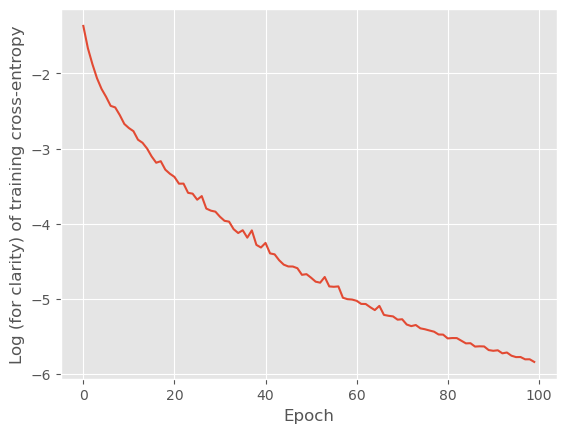

In [18]:
%%time
Ws_1, train_ces = train_nnet(
    train_Z, train_y,
    hid_layer_sizes=[50], 
    initial_Ws=None, mb_size=32, lr=0.3, max_epoch=100)
plt.plot(np.log(train_ces))
plt.xlabel('Epoch')
plt.ylabel('Log (for clarity) of training cross-entropy');

## Dùng mô hình Neural Network tìm được để dự đoán với dữ liệu huấn luyện và đánh giá kết quả

In [19]:
def compute_mbe(predicted_y, y):
    return np.mean(predicted_y != y) * 100

In [20]:
predicted_train_y = compute_nnet_output(Ws_1, train_Z, return_what='class')
train_mbe = compute_mbe(predicted_train_y, train_y)
assert str(np.round(train_mbe, 4)) == '0.002'

Ở HW3, độ lỗi MBE trên dữ liệu huấn luyện của mô hình Softmax Regression (cùng cách tiền xử lý) tốt nhất là 4.x%. Với mô hình Neural Network ở bài này, độ lỗi MBE trên dữ liệu huấn luyện đã giảm xuống 0.002% :-O.

Nhưng ta khoan hãy vui mừng, vì độ lỗi siêu thấp trên dữ liệu huấn luyện có thể là do "học vẹt". Ta hãy xem độ lỗi trên dữ liệu validation.

## Tiền xử lý dữ liệu validation, dùng mô hình Neural Network tìm được để dự đoán với dữ liệu validation và đánh giá kết quả

In [21]:
val_Z = add_ones(val_X)
predicted_val_y = compute_nnet_output(Ws_1, val_Z, return_what='class')
val_mbe = compute_mbe(predicted_val_y, val_y)
assert str(np.round(val_mbe, 4)) == '2.89'

Độ lỗi MBE trên dữ liệu validation cũng giảm theo (mặc dù không giảm nhiều như trên dữ liệu huấn luyện): từ 4.x% với mô hình Softmax Regression tốt nhất ở HW3 giảm xuống 2.89%! 

## Đưa ra ý tưởng cải tiến

Mô hình Neural Network hiện tại có độ lỗi trên dữ liệu huấn luyện nhỏ hơn khá nhiều so với độ lỗi trên dữ liệu validation (0.002% vs 2.89%). Đây là dấu hiệu cho thấy mô hình Neural Network hiện tại có thể đang bị "overfitting".

Nhiệm vụ của bạn (2đ): tìm hiểu về một phương pháp chống "overfitting" cho Neural Network và trình bày ở bên dưới để người đọc có thể hiểu được ý tưởng của phương pháp này (phương pháp này làm gì? tại sạo làm như vậy lại giúp chống "overfitting"?). Gợi ý tên một số phương pháp: "weight decay (L2 regularization)", "drop-out", "data augmentation", ... (bạn chỉ cần chọn một phương pháp thôi). Khi trình bày, nếu bạn có tham khảo ở đâu thì bạn nhớ ghi rõ nguồn.

YOUR ANSWER HERE \
- Để tăng độ chính xác cho quá trình học, đầu tiên sẽ tiền xử lý xử dữ liệu loại bỏ độ nghiêng của ảnh (tham khảo từ HW3)
- Sử dụng ý tưởng của phương pháp weight decay (L1 regularization) cho quá trình học

### L2 regularization
Với phương pháp Gradient Descent, quá trình train sẽ tìm các hệ số của ma trận trọng số $W$ sao cho hàm loss của $W$ này thấp nhất. Regularization cộng thêm 1 lượng bằng $\frac{\lambda}{2m}||W||^2$ (với $m$ là số lượng mẫu) vào hàm loss để điều chỉnh các trọng số của $W$ có giá trị nhỏ lại và trở nên gần $0$ hơn. Với Multi-layer Perceptron, việc các hệ số này nhỏ giúp cho nhiều hệ số trong các ma trận trọng số là nhỏ. Điều này tương ứng với việc số lượng các hidden units hoạt động (khác không) là nhỏ, cũng giúp cho MLP tránh được hiện tượng overfitting.

Khi ta đạo hàm thành phần regularization ta sẽ được $\frac{\lambda}{m} w$. Điều đó có nghĩa tại mỗi khi tính gradient descent ta chỉ cần cộng thêm $1$ lượng $\frac{\lambda}{m} w$.

Cụ thể đối với bài toán này, ta sẽ làm các bước sau:
- Khi tính Gradient tại lớp $l$, ta sẽ cộng thêm $1$ lượng $\frac{\lambda}{m} * W[l]$: $G = G + (lambda/m * W[l])$
- Khi cập nhật $W[l] = W[l] - lr * G$, lúc này $W[l]$ được cập nhật sẽ có số nhỏ hơn $W[l]$ khi không được cộng thêm $\frac{\lambda}{m} * W[l]$

*Tham khảo: https://machinelearningcoban.com/2017/03/04/overfitting/#-them-so-hang-vao-ham-mat-mat*

Nhiệm vụ kế tiếp của bạn (2đ): cài đặt phương pháp chống "overfitting" mà bạn đã tìm hiểu! Ở bên dưới, mình đã để sẵn các mục quen thuộc cho bạn, với mỗi mục thì bạn có thể tùy ý chèn thêm các cell để làm. 

Nếu phương pháp chống "overfitting" của bạn không liên quan đến việc tiền xử lý dữ liệu thì bạn có thể bỏ qua mục "Tiền xử lý dữ liệu huấn luyện". 

Ở mục "Tiền xử lý dữ liệu validation, dùng mô hình Neural Network tìm được để dự đoán với dữ liệu validation và đánh giá kết quả", bạn nhớ in ra độ lỗi MBE trên dữ liệu validation và so sánh với độ lỗi MBE hiện tại (2.89%); trong trường hợp kết quả không được cải thiện, bạn thử suy nghĩ xem tại sao lại như vậy, nếu không biết tại sao thì bạn cứ nói là không biết tại sao. 

Hai mục sau cùng ("Chọn ra cách tiền xử lý + mô hình Neural Network sau cùng là cách tiền xử lý + mô hình Neural Network mà có độ lỗi dự đoán thấp nhất trên dữ liệu validation" và "Dùng cách tiền xử lý + mô hình Neural Network sau cùng để đi thi thật!") là hai mục không bắt buộc (không có điểm) nhưng bạn nên làm cho đầy đủ. 

## Tiền xử lý dữ liệu huấn luyện

In [22]:
def deskew(X):
    # YOUR CODE HERE
    Z = np.zeros((X.shape[0], X.shape[1]))
    image_size = 28
    
    for i in range(0, X.shape[0]):
        I = X[i]
        
        # Tìm vị trí các điểm pixel > 0.5
        rows, cols = np.where(I.reshape(image_size, image_size) > 0.5)

        # Tìm tan = -a
        rows_nor = (rows - rows.mean()) / rows.std()
        cols_nor = (cols - cols.mean()) / cols.std()
        corr_coef = np.mean(rows_nor * cols_nor)
        a = corr_coef * cols.std() / rows.std()
        
        # Tìm O
        ic = np.tile(np.arange(0, image_size), image_size) + (rows.mean() - np.repeat(np.arange(0, image_size), image_size)) * (-a)
        ic[ic < 0] = 0
        ic[ic > 27] = 27
        ic = ic + np.repeat(np.arange(0, image_size * image_size, image_size), image_size)

        con = np.ceil(ic) - ic

        O = con * I[np.floor(ic).astype(int)] + (1 - con) * I[np.ceil(ic).astype(int)]
        
        Z[i] = O
        
    return Z

train_Z = add_ones(deskew(train_X))

## Tìm mô hình Neural Network từ dữ liệu huấn luyện

In [23]:
def train_nnet_regu(X, y, 
               hid_layer_sizes, 
               initial_Ws, mb_size, lr, max_epoch, lambda_):
    # Cách để khởi tạo tốt các trọng số khá là "bí hiểm"
    # nên mình sẽ làm cho bạn ;-)
    np.random.seed(0) # Cố định sự ngẫu nhiên để mình và bạn sẽ ra cùng kết quả
    n_classes = len(np.unique(y)) 
    if initial_Ws is None:
        layer_sizes = [X.shape[1] - 1] + hid_layer_sizes + [n_classes]
        Ws = [np.random.randn(layer_sizes[i] + 1, layer_sizes[i + 1]) 
              / np.sqrt(layer_sizes[i] + 1) 
              for i in range(len(layer_sizes) - 1)] 
    else:
        Ws = initial_Ws
    
    # Phần còn lại là của bạn
    # YOUR CODE HERE
    m = len(X)
    
    data_indexes = list(range(X.shape[0]))
    n_batch = X.shape[0] // mb_size
    
    cee_set = []
    
    for i in range(0, max_epoch):
        np.random.shuffle(data_indexes)
        for j in range(0, n_batch):
            mini_batch = data_indexes[j * mb_size : j * mb_size + mb_size]
            
            # Tính output của các tầng
            As = compute_nnet_output(Ws, X[mini_batch], return_what="all")
            
            # Tính ma trận Delta của tầng cuối As[-1]
                # Tính onehot của y, nrows là số minibatch
                # Mỗi minibatch ra được y_predict là 1 vector 10 phần tử, mỗi ptu là xác suất của 0 -> 9
            y_one_hot = np.zeros((mb_size, n_classes))
            y_one_hot[np.arange(mb_size), y[mini_batch]] = 1
                # Tính ma trận D
            D = As[-1] - y_one_hot
            
            # Tính gradient của layer cuối
            G = np.dot(As[-2].T, D) / len(As[-2]) + (lambda_/m) * Ws[-1]
            
            # Cập nhật W của layer cuối
            Ws[-1] = Ws[-1] - lr * G
            
            # Ws[len - 1]: tầng cuối đã tính
            # Cần tính từ Ws[len - 2]
            # Các vector đầu ra của tầng i là A[i+1]
            for l in range(len(Ws) - 2, -1, -1):
                D = np.dot(D, Ws[l + 1].T[:, 1:]) * As[l+1][:, 1:] * (1 - As[l+1][:, 1:])
                G = (np.dot(As[l].T, D) / len(As[l])) + (lambda_/m) * Ws[l]
                Ws[l] = Ws[l] - lr * G
                
        # Cross entropy
        P = compute_nnet_output(Ws, X, return_what="prob")
        cee = np.mean(-np.log(P)[np.arange(len(y)), y])
        cee_set.append(cee)
    
    return Ws, cee_set

CPU times: user 3min 56s, sys: 1.31 s, total: 3min 57s
Wall time: 59.3 s


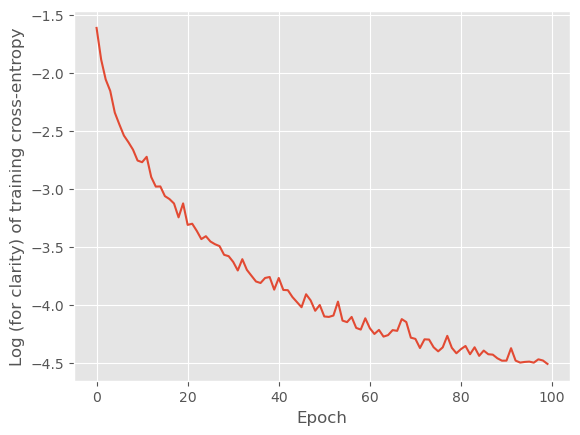

In [24]:
%%time
Ws_regu, train_ces_regu = train_nnet_regu(
    train_Z, train_y,
    hid_layer_sizes=[50], 
    initial_Ws=None, mb_size=32, lr=0.3, max_epoch=100, lambda_=1)
plt.plot(np.log(train_ces_regu))
plt.xlabel('Epoch')
plt.ylabel('Log (for clarity) of training cross-entropy');

## Dùng mô hình Neural Network tìm được để dự đoán với dữ liệu huấn luyện và đánh giá kết quả

In [25]:
predicted_train_y_regu = compute_nnet_output(Ws_regu, train_Z, return_what='class')
train_mbe_regu = compute_mbe(predicted_train_y_regu, train_y)
print(train_mbe_regu)

0.076


Độ lỗi MBE trên dữ liệu huấn luyện tăng từ 0.002% lên 0.076%! Tuy là tăng nhưng độ lỗi rất nhỏ.

## Tiền xử lý dữ liệu validation, dùng mô hình Neural Network tìm được để dự đoán với dữ liệu validation và đánh giá kết quả

In [26]:
val_Z = add_ones(deskew(val_X))
predicted_val_y_regu = compute_nnet_output(Ws_regu, val_Z, return_what='class')
val_mbe_regu = compute_mbe(predicted_val_y_regu, val_y)
print(val_mbe_regu)

1.82


Độ lỗi MBE trên dữ liệu validation giảm từ 2.89% xuống 1.82%! Giảm khá nhiều.

## Chọn ra cách tiền xử lý + mô hình Neural Network sau cùng là cách tiền xử lý + mô hình Neural Network mà có độ lỗi dự đoán thấp nhất trên dữ liệu validation

Như vậy có thể thấy rằng tuy là độ lỗi MBE của dữ liệu huấn luyện tăng lên 1 ít, tuy nhiên độ lỗi MBE trên dữ liệu validation giảm đáng kể và giải quyết được vấn đề Overfiting. \
Vậy chọn cách tiền xử lý `add_ones(deskew(...))` và mô hình có bộ trọng số `Ws_regu`

## Dùng cách tiền xử lý + mô hình Neural Network sau cùng để đi thi thật!

In [27]:
test_Z = add_ones(deskew(test_X))
predicted_test_y = compute_nnet_output(Ws_regu, test_Z, return_what='class')
test_mbe = compute_mbe(predicted_test_y, test_y)
print(test_mbe)

1.7999999999999998
